In [1]:
from argparse import Namespace
from classifier import MLP, CNNClassifier

from dataset import *
from vectorizer import *

import torch


/home/alexc/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def use_cuda():
    return torch.device("cpu" if torch.cuda.is_available() else "cpu")

args = Namespace (
    in_features=None,
    out_units=3,
    units_per_layer=[128, 64],
    dataset=None,
    optimizer="Adam",
    criterion="bce_ls",
    save_dir='../trained_models/bow.pth',
    batch_size=128,
    learning_rate=0.001,
    num_epochs=10,
    device=use_cuda(),
    binary_class=False,
    embed_dim=300,
    freeze_embedding=False,
    filter_sizes=[3, 4, 5],
    num_filters=[100, 100, 100],
    pretrained_embedding=None
)


                 

In [3]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/Tweets.csv")
args.in_features = len(args.dataset.get_vectorizer().text_vocab)
args.out_features = len(args.dataset.get_vectorizer().label_vocab)

[nltk_data] Downloading package stopwords to /home/alexc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
bow = BOWClassifier(args=args)
bow.setup()
bow.fit()

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


In [5]:
loss, acc, f1 = bow.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.623367049477317
75.31960227272725
68.29810228900428


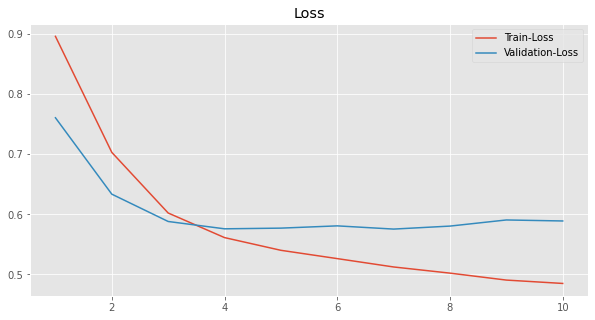

In [6]:
bow.plot_logs(title="Loss", legend=["Train-Loss", "Validation-Loss"])

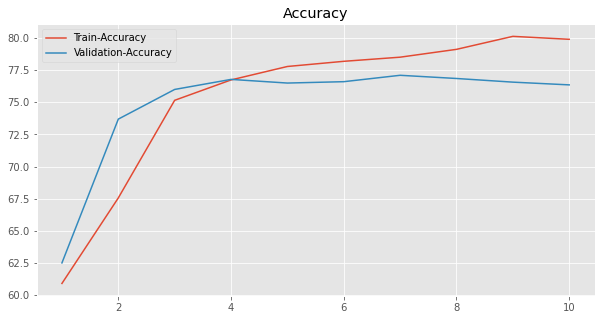

In [7]:
bow.plot_logs(title="Accuracy", legend=["Train-Accuracy", "Validation-Accuracy"])

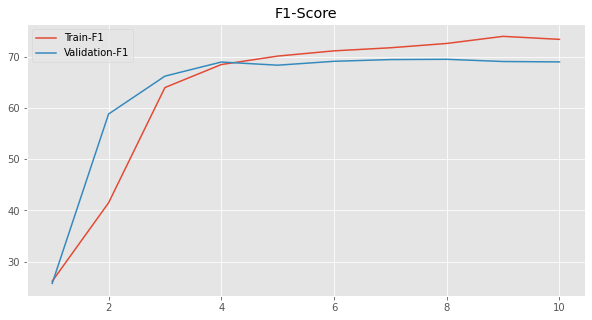

In [8]:
bow.plot_logs(title="F1-Score", legend=["Train-F1", "Validation-F1"])

In [4]:
import pandas as pd

df = pd.read_csv("../data/Tweets.csv")
vect = TextVectorizer.from_dataframe(df, "padded")
vect.vectorize("bad hello")
print(len(vect.text_vocab))

1015


In [5]:
embedding = vect.load_pretrained_embed("../data/crawl-300d-2M.vec")

1999995it [02:00, 16563.57it/s]


In [6]:
args.pretrained_embedding = embedding

In [12]:
import torch.nn as nn

class CNNClassifier(MLP):
    def __init__(self, args):
        super().__init__(args)

        # self._topology = nn.Sequential (
        #     nn.Embedding.from_pretrained(pretrained_embedding = args.pretrained_embedding, freeze=args.freeze_embedding),
        #     nn.ModuleList([
        #     nn.Conv1d(in_channels=args.embed_dim,
        #               out_channels=args.num_filters[i],
        #               kernel_size=args.filter_sizes[i])
        #     for i in range(len(args.filter_sizes))
        # ]),
        # nn.Linear(len(args.filter_sizes) * args.n_filters, args.output_dim),    
        # nn.Dropout(dropout)
        # )


        self.embedding = nn.Embedding.from_pretrained(args.pretrained_embedding,
                                                          freeze=args.freeze_embedding)
        
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=args.embed_dim,
                      out_channels=args.num_filters[i],
                      kernel_size=args.filter_sizes[i])
            for i in range(len(args.filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(args.num_filters), args.out_units)
        self.dropout = nn.Dropout(p=0.5)

        def forward(self, input_ids):
            """Perform a forward pass through the network.

            Args:
                input_ids (torch.Tensor): A tensor of token ids with shape
                    (batch_size, max_sent_length)

            Returns:
                logits (torch.Tensor): Output logits with shape (batch_size,
                    n_classes)
            """

            # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
            x_embed = self.embedding(x).float()

            # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
            # Output shape: (b, embed_dim, max_len)
            x_reshaped = x_embed.permute(0, 2, 1)

            # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
            x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

            # Max pooling. Output shape: (b, num_filters[i], 1)
            x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
                for x_conv in x_conv_list]
            
            # Concatenate x_pool_list to feed the fully connected layer.
            # Output shape: (b, sum(num_filters))
            x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                            dim=1)
            
            # Compute logits. Output shape: (b, n_classes)
            logits = self.fc(self.dropout(x_fc))

            return logits

In [7]:
cnn = CNNClassifier(args=args)
cnn.setup()
cnn.fit()

100%|██████████| 10/10 [22:44<00:00, 136.48s/it]


In [8]:
loss, acc, f1 = cnn.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.8957952775738456
63.92045454545455
30.135385601302236
